# Luminosity

In [ ]:
from spice.models import IcosphereModel
from spice.spectrum import simulate_observed_flux
from spice.spectrum.spectrum import simulate_monochromatic_luminosity
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody
import matplotlib.pyplot as plt
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

Let's use a simple, blackbody model just for the testing purposes, alogside with a solar-like model.

In [ ]:
bb = Blackbody()
model = IcosphereModel.construct(10000, 1., 1., [5772.], bb.parameter_names)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:222: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


To test the bolometric luminosity value, let's choose a wide range of wavelengths.

In [ ]:
vws = jnp.linspace(1., 10000000., 100000)

The observed flux is calculated for the distance of 10 parsecs by default.

(-10.0, 30000.0)

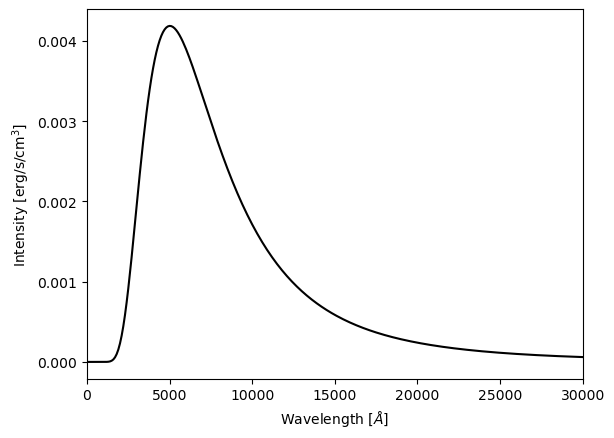

In [ ]:
observed_flux = simulate_observed_flux(bb.intensity, model, jnp.log10(vws))
plt.plot(vws, observed_flux[:, 0], color='black')
plt.gca().set_xlabel('Wavelength [$\\AA$]')
plt.gca().set_ylabel('Intensity [erg/s/cm$^3$]')
plt.gca().set_xlim(-10., 30000)

Now let's calculate the monochromatic luminosity.

(-10.0, 30000.0)

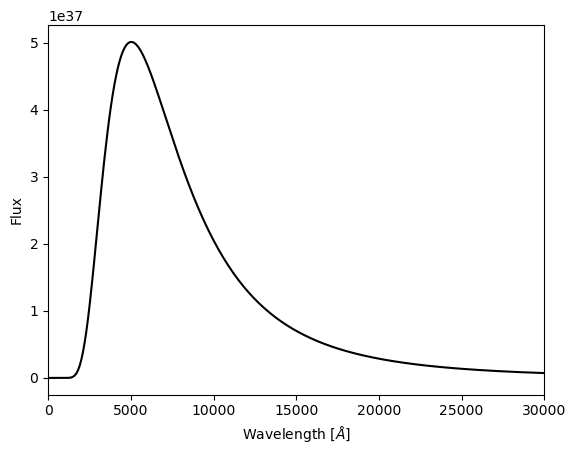

In [ ]:
mono_luminosity = simulate_monochromatic_luminosity(bb.flux, model, jnp.log10(vws), chunk_size=1000)
plt.plot(vws, mono_luminosity[:, 0], color='black')
plt.gca().set_xlabel('Wavelength [$\\AA$]')
plt.gca().set_ylabel('Flux')
plt.gca().set_xlim(-10., 30000)

# Filters

Let's use the ```Filter``` subclasses to check the passband luminosities.

In [ ]:
from spice.spectrum.filter import BesselB, BesselI, GaiaG, JohnsonV

bessel_b = BesselB()
bessel_i = BesselI()
gaia_g = GaiaG()
johnson_v = JohnsonV()

(-10.0, 30000.0)

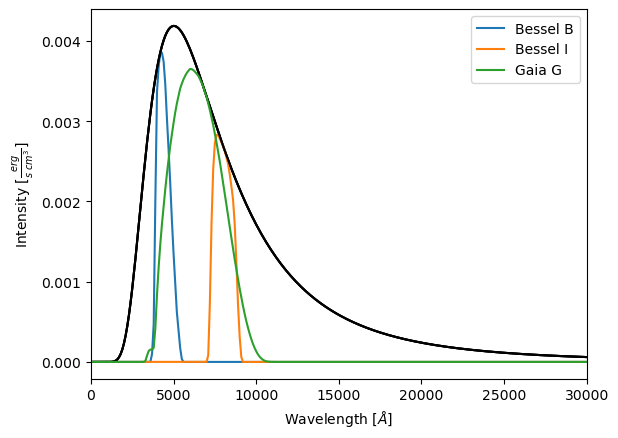

In [ ]:
bessel_b.plot_filter_responses_for_wavelengths(vws, observed_flux[:, 0])
bessel_i.plot_filter_responses_for_wavelengths(vws, observed_flux[:, 0])
gaia_g.plot_filter_responses_for_wavelengths(vws, observed_flux[:, 0])
plt.gca().set_xlim(-10, 30000);

The passband luminosities can be calculated using the ```AB_passband_luminosity``` function.

In [ ]:
from spice.spectrum.spectrum import AB_passband_luminosity
C: float = 299792.458  # km/s

In [ ]:
solar_apparent_mag_B = AB_passband_luminosity(bessel_b, vws, observed_flux[:, 0])
solar_apparent_mag_I = AB_passband_luminosity(bessel_i, vws, observed_flux[:, 0])
solar_apparent_mag_G = AB_passband_luminosity(gaia_g, vws, observed_flux[:, 0])
solar_johnson_v = AB_passband_luminosity(johnson_v, vws, observed_flux[:, 0])

print("Apparent magnitude of the Sun")
print("Bessel B:\t", solar_apparent_mag_B, "mag")
print("Bessel I:\t", solar_apparent_mag_I, "mag")
print("Gaia G:\t\t", solar_apparent_mag_G, "mag")

print("Johnson V:\t", solar_johnson_v, "mag")

Apparent magnitude of the Sun
Bessel B:	 5.381636 mag
Bessel I:	 4.5054903 mag
Gaia G:		 4.7385616 mag
Johnson V:	 4.860841 mag


# Bolometric luminosity of the Sun

The bolometric luminosity of the Sun is the energy that is outputted by the whole Sun. To calculate that, we need to obtain the total flux first.

In [ ]:
from spice.spectrum import luminosity, absolute_bol_luminosity

In [ ]:
solar_luminosity = luminosity(bb.flux, model, vws)
print("Sun's bolometric luminosity:", solar_luminosity, "erg/s")
print("Sun's absolute bolometric luminosity:", absolute_bol_luminosity(solar_luminosity), "mag")

Sun's bolometric luminosity: 3.8268478e+33 erg/s
Sun's absolute bolometric luminosity: 4.7403016 mag


Let's compare that to the theoretical luminosity:

$L=4\pi R^2 \sigma T^4$

In [ ]:
sigma = (5.67*1e-8*u.W/(u.m**2)/(u.K**4)).to(u.erg/(u.cm**2)/(u.s)/(u.K**4))

print("Theoretical luminosity of the Sun:", 0.9997011*jnp.sum(model.areas)*(u.solRad.to(u.cm)**2)*sigma*(5772*u.K)**4, "erg/s")

Theoretical luminosity of the Sun: 3.8254498e+33 erg/s
